In [33]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.signal import find_peaks

In [34]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
interApi = lumapi.INTERCONNECT(hide = False)

In [35]:
# units
um = 1e-6
nm = 1e-9

lr = np.array([552.82, 55.28, 27.64])*um

wavelength = 1550*nm

# index
# neff = 2.353170
# ng = 4.3458796

neff = 2.354 
ng = 4.33683

wvlngth_start = 1.500 * um
wvlngth_stop = 1.600 * um

coef_coupler = 0.2
number_of_points = 50e3

# Simualation

## Add ONA

In [36]:
interApi.switchtolayout()
interApi.select('ONA')
interApi.delete()

# ONA

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 2)
interApi.set('input parameter', 2)
interApi.set('start frequency', c/wvlngth_start)
interApi.set('stop frequency', c/wvlngth_stop)
interApi.set('number of points', number_of_points)

## $FSR(\lambda)=1nm$

In [37]:
interApi.switchtolayout()
interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

# Waveguide

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_1')
interApi.set('coupling coefficient 1', coef_coupler)
# interApi.set('coupling coefficient 2', coef_coupler)

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_2')
interApi.set('coupling coefficient 1', coef_coupler)
# interApi.set('coupling coefficient 2', coef_coupler)

interApi.addelement('Straight Waveguide')
interApi.set('name', 'wg_1')
# interApi.set('frequency', (c/(wavelength)))
interApi.set('length', lr[0]/2)
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)

interApi.copy()
interApi.set('name', 'wg_2')

In [38]:
#positions
interApi.setposition('ONA', 0, -400)
interApi.setposition('wg_1', 0,-100)
interApi.setposition('wg_2', 0, 100)
interApi.setposition('coupler_1', -250, -200)
interApi.setposition('coupler_2', 250, -200)

In [39]:
# connection

interApi.connect("ONA", "output", "coupler_1", "port 1")
interApi.connect("coupler_1", "port 4", "wg_1", "port 1")
interApi.connect("coupler_1", "port 2", "wg_2", "port 1")
interApi.connect("wg_1", "port 2", "coupler_2", "port 2")
interApi.connect("wg_2", "port 2", "coupler_2", "port 4")
interApi.connect("coupler_2", "port 3", "ONA", "input 2")
interApi.connect("coupler_1", "port 3", "ONA", "input 1")

1.0

In [40]:
interApi.run()

In [41]:
gain_1nm = interApi.getresult("ONA", "input 1/mode 1/gain")

gain_2_1nm = interApi.getresult("ONA", "input 2/mode 1/gain")

C:\Users\alves\AppData\Local\Temp\ipykernel_20140\2766845207.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1545, -45, f'{float(x_min_1 - x_min_2):.1f} nm')


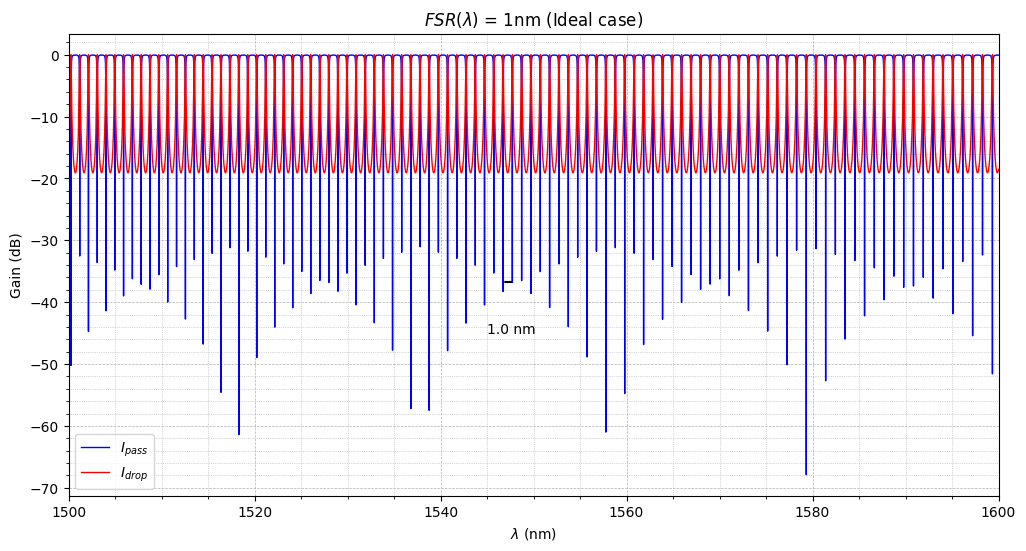

In [66]:
min_indices, _ = find_peaks(-np.array(gain_1nm['TE gain (dB)']))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[50:52]  
    x_min_1, x_min_2 = gain_1nm['wavelength'][min_1] / nm, gain_1nm['wavelength'][min_2] / nm
    y_min = gain_1nm['TE gain (dB)'][min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(gain_1nm['wavelength']/nm , gain_1nm['TE gain (dB)'], lw=1, label='$I_{pass}$', color='blue')
    plt.plot(gain_2_1nm['wavelength']/nm , gain_2_1nm['TE gain (dB)'], lw=1, label='$I_{drop}$', color='red')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1545, -45, f'{float(x_min_1 - x_min_2):.1f} nm')

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 1nm (Ideal case)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_1nm', bbox_inches='tight')
    plt.show()

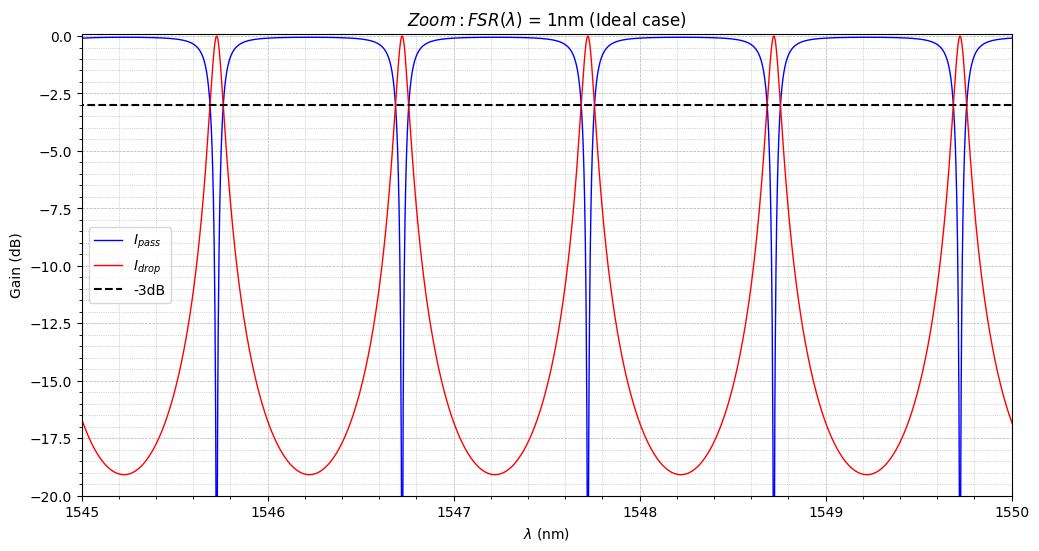

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(gain_1nm['wavelength']/nm , gain_1nm['TE gain (dB)'], lw=1, label='$I_{pass}$', color='blue')
plt.plot(gain_2_1nm['wavelength']/nm , gain_2_1nm['TE gain (dB)'], lw=1, label='$I_{drop}$', color='red')
plt.plot([1445, 1550], [-3, -3], ls='--', color='black', label='-3dB')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Gain (dB)')

plt.xlim([1545, 1550])
plt.ylim([-20, 0.1])
    
plt.title('$Zoom: FSR(\lambda)$ = 1nm (Ideal case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1nm_zoom', bbox_inches='tight')
plt.show()

In [43]:
FSR_1_1nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_1nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_1nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_1nm['TE free spectral range (m)'])

wavelength_2 = np.array(FSR_2_1nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_1nm['TE free spectral range (m)'])  

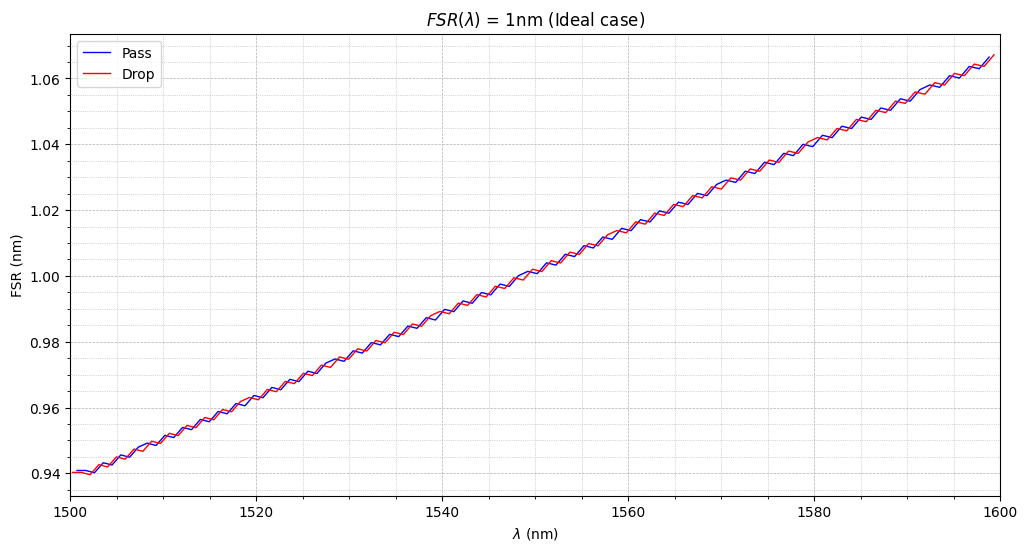

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Pass', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Drop', color='red')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 1nm (Ideal case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda) = 10nm$

In [45]:
interApi.switchtolayout()
interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

# Waveguide

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_1')
interApi.set('coupling coefficient 1', coef_coupler)
# interApi.set('coupling coefficient 2', coef_coupler)

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_2')
interApi.set('coupling coefficient 1', coef_coupler)
# interApi.set('coupling coefficient 2', coef_coupler)

interApi.addelement('Straight Waveguide')
interApi.set('name', 'wg_1')
interApi.set('frequency', (c/(wavelength)))
interApi.set('length', lr[1]/2)
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)

interApi.copy()
interApi.set('name', 'wg_2')

In [46]:
#positions
interApi.setposition('ONA', 0, -400)
interApi.setposition('wg_1', 0,-100)
interApi.setposition('wg_2', 0, 100)
interApi.setposition('coupler_1', -250, -200)
interApi.setposition('coupler_2', 250, -200)

In [47]:
# connection
interApi.connect("ONA", "output", "coupler_1", "port 1")
interApi.connect("coupler_1", "port 4", "wg_1", "port 1")
interApi.connect("coupler_1", "port 2", "wg_2", "port 1")
interApi.connect("wg_1", "port 2", "coupler_2", "port 2")
interApi.connect("wg_2", "port 2", "coupler_2", "port 4")
interApi.connect("coupler_2", "port 3", "ONA", "input 2")
interApi.connect("coupler_1", "port 3", "ONA", "input 1")

1.0

In [48]:
interApi.run()

In [49]:
gain_10nm = interApi.getresult("ONA", "input 1/mode 1/gain")

gain_2_10nm = interApi.getresult("ONA", "input 2/mode 1/gain")

C:\Users\alves\AppData\Local\Temp\ipykernel_20140\2934289942.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1545, -60, f'{float(x_min_1 - x_min_2):.1f} nm')


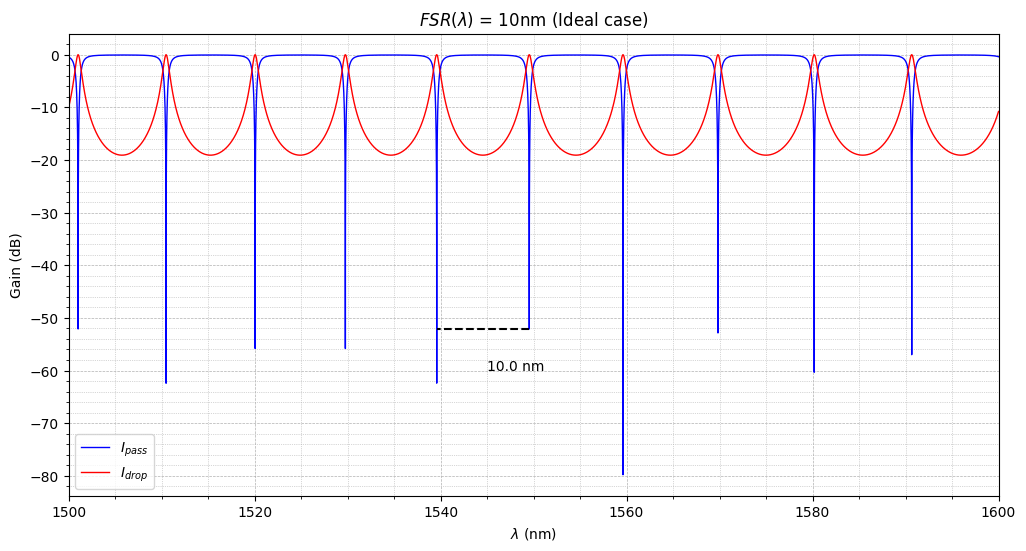

In [65]:
min_indices, _ = find_peaks(-np.array(gain_10nm['TE gain (dB)']))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[4:6]  
    x_min_1, x_min_2 = gain_10nm['wavelength'][min_1] / nm, gain_10nm['wavelength'][min_2] / nm
    y_min = gain_10nm['TE gain (dB)'][min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(gain_10nm['wavelength']/nm , gain_10nm['TE gain (dB)'], lw=1, label='$I_{pass}$', color='blue')
    plt.plot(gain_2_10nm['wavelength']/nm , gain_2_10nm['TE gain (dB)'], lw=1, label='$I_{drop}$', color='red')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1545, -60, f'{float(x_min_1 - x_min_2):.1f} nm')

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 10nm (Ideal case)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_10nm', bbox_inches='tight')
    plt.show()

In [51]:
FSR_1_10nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_10nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_10nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_10nm['TE free spectral range (m)'])

wavelength_2 = np.array(FSR_2_10nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_10nm['TE free spectral range (m)'])  

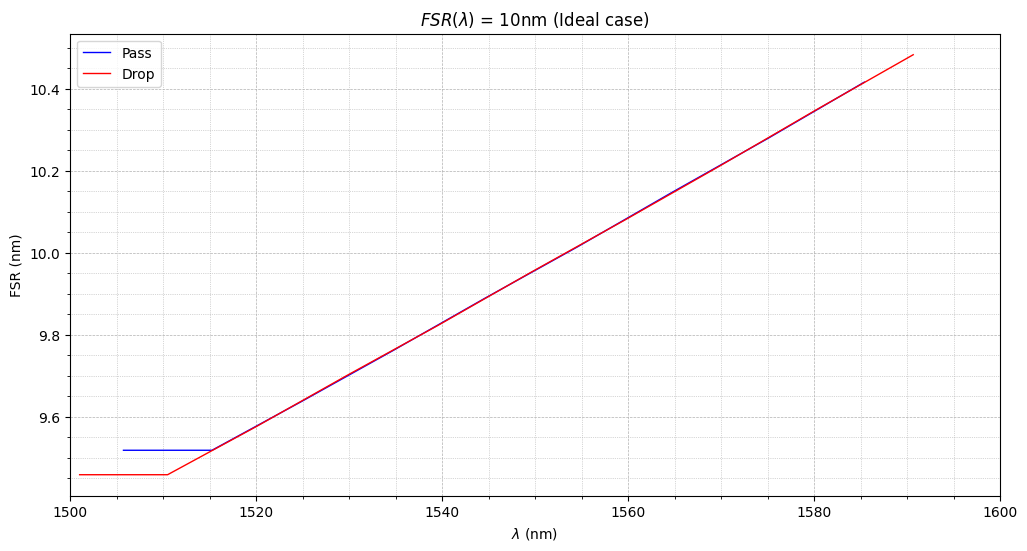

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Pass', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Drop', color='red')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 10nm (Ideal case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_10nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda)=20nm$

In [53]:
interApi.switchtolayout()
interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

# Waveguide

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_1')
interApi.set('coupling coefficient 1', coef_coupler)
# interApi.set('coupling coefficient 2', coef_coupler)

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_2')
interApi.set('coupling coefficient 1', coef_coupler)
# interApi.set('coupling coefficient 2', coef_coupler)

interApi.addelement('Straight Waveguide')
interApi.set('name', 'wg_1')
interApi.set('frequency', (c/(wavelength)))
interApi.set('length', lr[2]/2)
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)

interApi.copy()
interApi.set('name', 'wg_2')

In [54]:
#positions
interApi.setposition('ONA', 0, -400)
interApi.setposition('wg_1', 0,-100)
interApi.setposition('wg_2', 0, 100)
interApi.setposition('coupler_1', -250, -200)
interApi.setposition('coupler_2', 250, -200)

In [55]:
# connection
interApi.connect("ONA", "output", "coupler_1", "port 1")
interApi.connect("coupler_1", "port 4", "wg_1", "port 1")
interApi.connect("coupler_1", "port 2", "wg_2", "port 1")
interApi.connect("wg_1", "port 2", "coupler_2", "port 2")
interApi.connect("wg_2", "port 2", "coupler_2", "port 4")
interApi.connect("coupler_2", "port 3", "ONA", "input 2")
interApi.connect("coupler_1", "port 3", "ONA", "input 1")

1.0

In [56]:
interApi.run()

In [57]:
gain_20nm = interApi.getresult("ONA", "input 1/mode 1/gain")

gain_2_20nm = interApi.getresult("ONA", "input 2/mode 1/gain")

C:\Users\alves\AppData\Local\Temp\ipykernel_20140\3118549579.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1548, -65, f'{float(x_min_1 - x_min_2):.1f} nm')


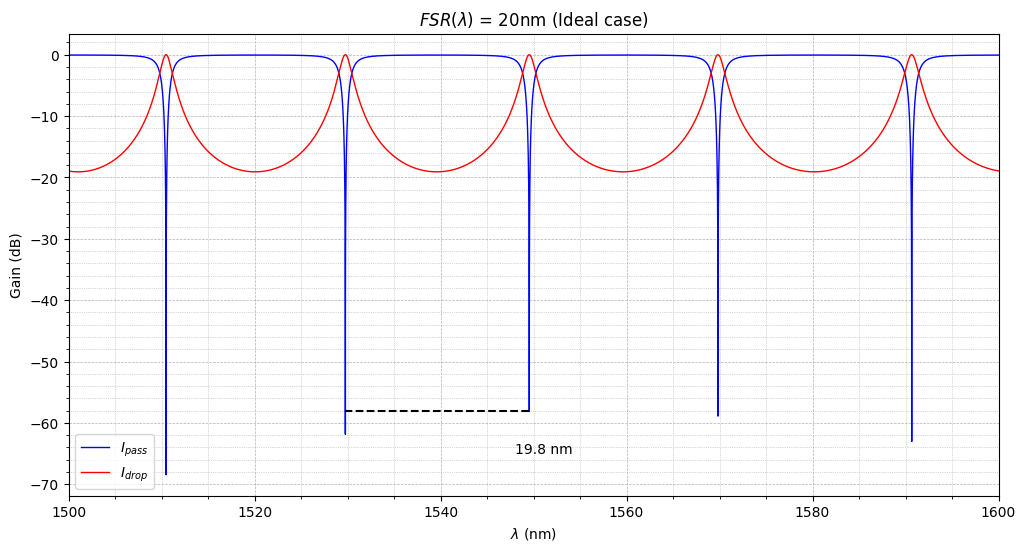

In [63]:
min_indices, _ = find_peaks(-np.array(gain_20nm['TE gain (dB)']))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[2:4] 
    x_min_1, x_min_2 = gain_20nm['wavelength'][min_1] / nm, gain_20nm['wavelength'][min_2] / nm
    y_min = gain_20nm['TE gain (dB)'][min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(gain_20nm['wavelength'] / nm, gain_20nm['TE gain (dB)'], lw=1, label='$I_{pass}$', color='blue')
    plt.plot(gain_2_20nm['wavelength'] / nm, gain_2_20nm['TE gain (dB)'], lw=1, label='$I_{drop}$', color='red')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1548, -65, f'{float(x_min_1 - x_min_2):.1f} nm')

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 20nm (Ideal case)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_20nm', bbox_inches='tight')

    plt.show()

In [59]:
FSR_1_20nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_20nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_20nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_20nm['TE free spectral range (m)'])

wavelength_2 = np.array(FSR_2_20nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_20nm['TE free spectral range (m)'])  

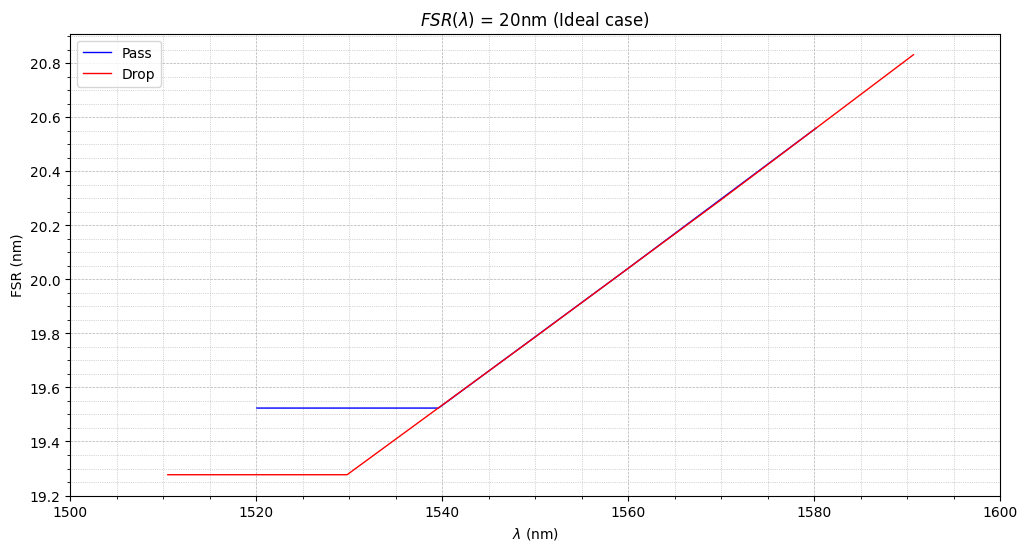

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Pass', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Drop', color='red')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 20nm (Ideal case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_20nm_x_wvlength', bbox_inches='tight')
plt.show()

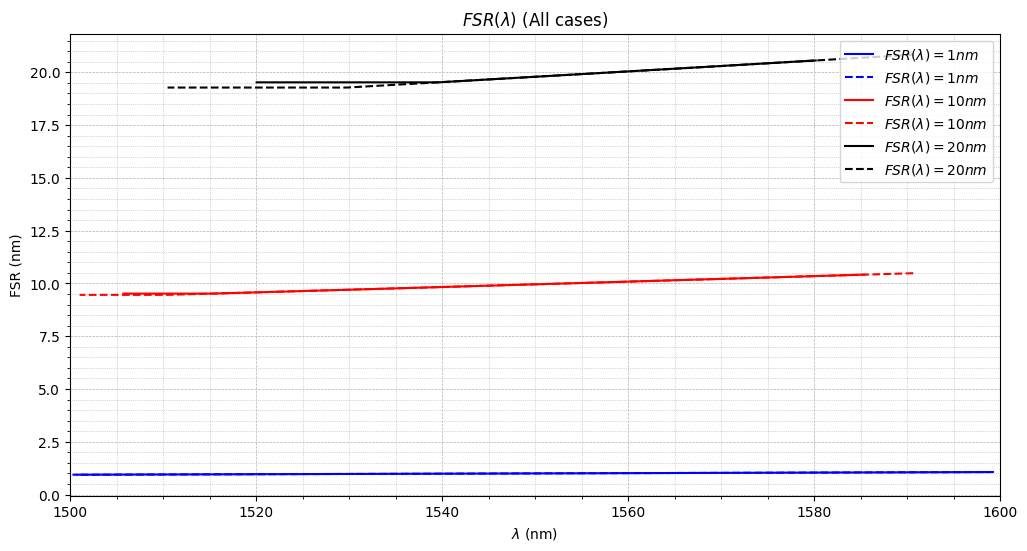

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(FSR_1_1nm['wavelength'] / nm, FSR_1_1nm['TE free spectral range (m)']/nm, lw=1.5, label='$FSR(\lambda)=1nm$', color='blue')
plt.plot(FSR_2_1nm['wavelength'] / nm, FSR_2_1nm['TE free spectral range (m)']/nm, lw=1.5, ls = '--', label='$FSR(\lambda)=1nm$', color='blue')

plt.plot(FSR_1_10nm['wavelength'] / nm, FSR_1_10nm['TE free spectral range (m)']/nm, lw=1.5, label='$FSR(\lambda)=10nm$', color='red')
plt.plot(FSR_2_10nm['wavelength'] / nm, FSR_2_10nm['TE free spectral range (m)']/nm, lw=1.5, ls = '--', label='$FSR(\lambda)=10nm$', color='red')

plt.plot(FSR_1_20nm['wavelength'] / nm, FSR_1_20nm['TE free spectral range (m)']/nm, lw=1.5, label='$FSR(\lambda)=20nm$', color='black')
plt.plot(FSR_2_20nm['wavelength'] / nm, FSR_2_20nm['TE free spectral range (m)']/nm, lw=1.5, ls = '--', label='$FSR(\lambda)=20nm$', color='black')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ (All cases)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1_10_20nm_x_wvlength', bbox_inches='tight')
plt.show()